# This notebook has the commands for creating a horizontal bar chart for the ADHD proportion data within communities

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [133]:
filtered_data_arms1 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/list_ADHDscores_ARMS2_arms1xgb_merged.csv")
#data_arms2 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_list_ARMS2_merged.csv")
filtered_data_arms1

,subjectkey,ADHD1,ADHD2,ADHD3,ADHD4,ADHDcomposite,community
0,NDAR_INV00J52GPG,Ctrl,Ctrl,Ctrl,Ctrl,0.364275,3
1,NDAR_INV00NPMHND,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,1
2,NDAR_INV01NAYMZH,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,3
3,NDAR_INV021403LF,ADHD,ADHD,Ctrl,Ctrl,1.444422,7
4,NDAR_INV022ZVCT8,Ctrl,Ctrl,Ctrl,Ctrl,-0.413990,4
...,...,...,...,...,...,...,...
3171,NDAR_INVZZ3P1ZFJ,Ctrl,Ctrl,Ctrl,Ctrl,1.137971,0
3172,NDAR_INVZZ6ZJ2KY,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,3
3173,NDAR_INVZZ81LEEV,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,0
3174,NDAR_INVZZZ2ALR6,Ctrl,Ctrl,Ctrl,Ctrl,0.033034,1


In [134]:
#currently keeping all communities, regardless of size, because we are trying to evaluate across the arms with the overfit xgb model

#communities_more_than_100_arms1 = data_arms1['community'].value_counts()[data_arms1['community'].value_counts() > 100].index
#communities_more_than_100_arms2 = data_arms2['community'].value_counts()[data_arms2['community'].value_counts() > 100].index

#filtered_data_arms1 = data_arms1[data_arms1['community'].isin(communities_more_than_100_arms1)]
#filtered_data_arms2 = data_arms2[data_arms2['community'].isin(communities_more_than_100_arms2)]

In [135]:
#cast community as a category

filtered_data_arms1['community'] = filtered_data_arms1['community'].astype('category')
#filtered_data_arms2['community'] = filtered_data_arms2['community'].astype('category')

In [136]:
#function to determine the grouping of all possible adhd label combinations/conditions

def filter_adhd(df, **conditions):
    query = ' & '.join([f"{k} == '{v}'" for k, v in conditions.items()])
    return df.query(query)

In [137]:
#all the possible adhd label combinations/conditions

conditions_arms1 = [
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'}
]

conditions_arms2 = conditions_arms1  # The conditions are the same for arms2

In [138]:
#determine the counts for the condition groups

groups_arms1 = [filtered_data_arms1] + [filter_adhd(filtered_data_arms1, **cond) for cond in conditions_arms1]
#groups_arms2 = [filtered_data_arms2] + [filter_adhd(filtered_data_arms2, **cond) for cond in conditions_arms2]
groups_arms1

[            subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
 0     NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275         3
 1     NDAR_INV00NPMHND  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990         1
 2     NDAR_INV01NAYMZH  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990         3
 3     NDAR_INV021403LF  ADHD  ADHD  Ctrl  Ctrl       1.444422         7
 4     NDAR_INV022ZVCT8  Ctrl  Ctrl  Ctrl  Ctrl      -0.413990         4
 ...                ...   ...   ...   ...   ...            ...       ...
 3171  NDAR_INVZZ3P1ZFJ  Ctrl  Ctrl  Ctrl  Ctrl       1.137971         0
 3172  NDAR_INVZZ6ZJ2KY  Ctrl  Ctrl  Ctrl  Ctrl      -0.189392         3
 3173  NDAR_INVZZ81LEEV  Ctrl  Ctrl  Ctrl  Ctrl      -0.189392         0
 3174  NDAR_INVZZZ2ALR6  Ctrl  Ctrl  Ctrl  Ctrl       0.033034         1
 3175  NDAR_INVZZZNB0XC  ADHD  ADHD  ADHD  Ctrl       0.899638         1
 
 [3176 rows x 7 columns],
             subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
 0     NDAR_INV00J52GPG

In [139]:
#better display of the counts

for group in groups_arms1:
    if not group.empty:
        print(group.head(1))
        print(len(group))

#outputs are in order: total, no adhd, adhd1, adhd2, adhd3, adhd4

         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275         3
3176
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275         3
2928
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
158  NDAR_INV20CNYBBC  ADHD  Ctrl  Ctrl  Ctrl       1.741991         2
7
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
3  NDAR_INV021403LF  ADHD  ADHD  Ctrl  Ctrl       1.444422         7
90
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
48  NDAR_INV0JAG7BGC  ADHD  ADHD  ADHD  Ctrl       1.936428         3
55
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
72  NDAR_INV0UMM15GY  ADHD  ADHD  ADHD  ADHD       3.435609         0
96


In [140]:
#for group in groups_arms2:
#    if not group.empty:
#        print(group.head(1))
#        print(len(group))

In [141]:
#functions to summarize the label counts into one dataframe

def summarize_by_label(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'ADHD'].assign(ADHD=label)

def summarize_by_label_ctrl(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'Ctrl'].assign(ADHD='Ctrl')

In [142]:
summary_data_arms1_ctrl_adhd1 = summarize_by_label_ctrl(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD1 = summarize_by_label(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD2 = summarize_by_label(filtered_data_arms1, 'ADHD2')
summary_data_arms1_ADHD3 = summarize_by_label(filtered_data_arms1, 'ADHD3')
summary_data_arms1_ADHD4 = summarize_by_label(filtered_data_arms1, 'ADHD4')

In [143]:
#summary_data_arms2_ctrl_adhd4 = summarize_by_label_ctrl(filtered_data_arms2, 'ADHD1')
#summary_data_arms2_ADHD1 = summarize_by_label(filtered_data_arms2, 'ADHD1')
#summary_data_arms2_ADHD2 = summarize_by_label(filtered_data_arms2, 'ADHD2')
#summary_data_arms2_ADHD3 = summarize_by_label(filtered_data_arms2, 'ADHD3')
#summary_data_arms2_ADHD4 = summarize_by_label(filtered_data_arms2, 'ADHD4')

In [144]:
#combine the summaries together

summary_data_arms1_combined = pd.concat([summary_data_arms1_ctrl_adhd1, summary_data_arms1_ADHD1, summary_data_arms1_ADHD2, summary_data_arms1_ADHD3, summary_data_arms1_ADHD4])
#summary_data_arms2_combined = pd.concat([summary_data_arms2_ctrl_adhd4, summary_data_arms2_ADHD1, summary_data_arms2_ADHD2, summary_data_arms2_ADHD3, summary_data_arms2_ADHD4])
summary_data_arms1_combined

,community,ADHD1,count,ADHD,ADHD2,ADHD3,ADHD4
1,0,Ctrl,705,Ctrl,NaN,NaN,NaN
3,1,Ctrl,631,Ctrl,NaN,NaN,NaN
5,2,Ctrl,364,Ctrl,NaN,NaN,NaN
7,3,Ctrl,390,Ctrl,NaN,NaN,NaN
9,4,Ctrl,323,Ctrl,NaN,NaN,NaN
11,5,Ctrl,213,Ctrl,NaN,NaN,NaN
13,6,Ctrl,123,Ctrl,NaN,NaN,NaN
15,7,Ctrl,56,Ctrl,NaN,NaN,NaN
17,8,Ctrl,123,Ctrl,NaN,NaN,NaN
0,0,ADHD,60,ADHD1,NaN,NaN,NaN


In [145]:
#function to aggregate the new summary data

def aggregate_summary_data(summary_data):
    return summary_data.groupby(['community', 'ADHD'],observed=False).agg(count=('count', 'sum')).reset_index()

In [146]:
agg_data_arms1_test = aggregate_summary_data(summary_data_arms1_combined)
#agg_data_arms2_test = aggregate_summary_data(summary_data_arms2_combined)
agg_data_arms1_test

,community,ADHD,count
0,0,ADHD1,60
1,0,ADHD2,58
2,0,ADHD3,33
3,0,ADHD4,22
4,0,Ctrl,705
5,1,ADHD1,51
6,1,ADHD2,51
7,1,ADHD3,35
8,1,ADHD4,22
9,1,Ctrl,631


In [147]:
#calculate the relevant proportions and add it as a new column

agg_data_arms1_test['proportion'] = agg_data_arms1_test.groupby('community', observed=False)['count'].transform(lambda x: x / x.sum())
agg_data_arms1_test

,community,ADHD,count,proportion
0,0,ADHD1,60,0.068337
1,0,ADHD2,58,0.066059
2,0,ADHD3,33,0.037585
3,0,ADHD4,22,0.025057
4,0,Ctrl,705,0.802961
5,1,ADHD1,51,0.064557
6,1,ADHD2,51,0.064557
7,1,ADHD3,35,0.044304
8,1,ADHD4,22,0.027848
9,1,Ctrl,631,0.798734


In [148]:
#pivot the data to prepare it for visualization

df_pivot = agg_data_arms1_test.pivot(index='community', columns='ADHD', values='proportion')
df_pivot = df_pivot.sort_index()
df_pivot

ADHD,ADHD1,ADHD2,ADHD3,ADHD4,Ctrl
community,,,,,
0,0.068337,0.066059,0.037585,0.025057,0.802961
1,0.064557,0.064557,0.044304,0.027848,0.798734
2,0.025510,0.020408,0.017857,0.007653,0.928571
3,0.104811,0.099656,0.072165,0.053265,0.670103
4,0.062663,0.062663,0.026110,0.005222,0.843342
5,0.058824,0.058824,0.035294,0.011765,0.835294
6,0.083333,0.083333,0.053571,0.047619,0.732143
7,0.060606,0.060606,0.015152,0.015152,0.848485
8,0.060000,0.060000,0.033333,0.026667,0.820000


<Figure size 1200x1000 with 0 Axes>

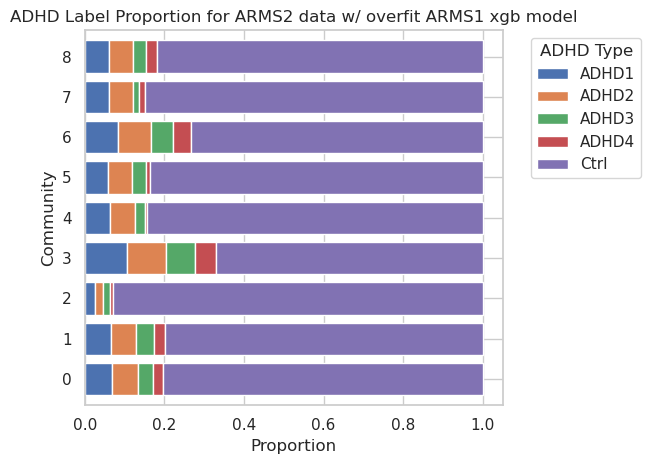

In [151]:
#plot the horizontal bar chart of the adhd label proportion data

#create the horizontal stacked bar chart
plt.figure(figsize=(12, 10))
ax = df_pivot.plot(kind='barh', stacked=True, width=0.8)

#customize the plot
plt.title('ADHD Label Proportion for ARMS2 data w/ overfit ARMS1 xgb model')
plt.xlabel('Proportion')
plt.ylabel('Community')

#remove the legend from its current position
plt.legend().remove()

#add a legend to the right of the plot
plt.legend(title='ADHD Type', bbox_to_anchor=(1.05, 1), loc='upper left')

#add percentage labels on the bars
#for c in ax.containers:
#    ax.bar_label(c, fmt='%.2f%%', label_type='center')

#adjust layout and display the plot
plt.tight_layout()
plt.savefig('./list_adhd_proportions_arms2data_arms1xgb.png', dpi=300, bbox_inches='tight')
plt.show()